# Chicago Crime Records SVM Single Crime Prediction

## **Student Details**
**Name:** Deborah Djon</br>
**Student Number:** 6197219</br>
**Module Code:** CA683</br>
**Module Name:** Data Analytics & Data Mining</br>
**Lecturer:** Dr. Andrew McCarren</br>

## **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

## **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [ ]:
# Install any required packages.
!pip install -U -q imbalanced-learn # https://github.com/scikit-learn-contrib/imbalanced-learn
!pip install -U -q PyDrive          # https://github.com/googlearchive/PyDrive
!pip install -U -q shap             # https://github.com/slundberg/shap

In [2]:
## Data analysis imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from datetime import datetime
import pickle

import sklearn
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score#, plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, pearsonr, spearmanr

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from itertools import combinations

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
#import shap

In [ ]:
# Make graphics background white in dark mode
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' }) 
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')  
data = pd.read_csv('ChicagoCrimeRecords.csv')

## **Data Transformation/Feature Engineering**

In [ ]:
# Randomly sample our dataset, so that it is small enough to work with.
data = data.sample(10000, random_state = 785)

In [ ]:
data.dropna(inplace = True)

In [ ]:
data = shuffle(data)

In [ ]:
# Drop any classes with less than 5 instances, as SMOTE will be unable to work with them (as it uses 3 k-neighbours).
has_min_class_count = data["Primary Type"].value_counts() > 5
data = data[data["Primary Type"].isin(has_min_class_count[has_min_class_count].index)]


In [ ]:
# Create a new feature for the weekday, month, and hour on in, or on which the crime occurred.
data["Weekday"] = data.Date.map(lambda x: datetime(month = int(x[:2]),day = int(x[3:5]), year = int(x[6:10])).weekday())
data["Month"] = data.Date.map(lambda x: int(x[:2]))
data["Hour"] = data.Date.map(lambda x: int(x[11:13]) if x[-2:] == "AM" else int(x[11:13]) + 12)

In [ ]:
# Remove any features that we are confident will not be of any use to our model.
data.drop(
    columns = [
        'Arrest',        # Occurs after the crime has been classified.
        'Case Number',   # Assigned after the crime has occurred.
        'Date',          # Replaced by 'Weekday', 'Month' and 'Hour'.
        'Description',   # A more granular version of 'Primary Type'.
        'FBI Code',      # An encoded form of 'Primary Type'.
        'Location',      # Replaced by 'Latitude', 'Longitude', 'X Coordinate', 'Y Coordinate'.
        'ID',            # Provides zero insight into the crime as it is simply an index for each row.
        'IUCR',          # An encoded form of 'Primary Type'.
        'Updated On'],   # Updated after the crime has already been recorded.
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
# Encode the 'Block', 'Domestic' and 'Location Description' features.
data['Block'] = data['Block'].astype('category')
data['Block'] = data['Block'].cat.codes

data['Domestic'] = data['Domestic'].astype(int)

data['Location Description'] = data['Location Description'].astype('category')
data['Location Description'] = data['Location Description'].cat.codes

In [ ]:
# Create a new feature, denoting whether or not a specific crime occurred.
data['Theft'] = 0
data.loc[data['Primary Type'] == 'THEFT', 'Theft'] = 1

data['Homicide'] = 0
data.loc[data['Primary Type'] == 'HOMICIDE', 'Homicide'] = 1

In [ ]:
# Test for multicollinearity between our nominal categorical features using a chi² test of independence.
nominal_features = [
    'Beat',
    'Block',
    'Community Area',
    'District',
    'Domestic',
    'Location Description']

for pair in list(combinations(nominal_features, 2)):
  test_result = chi2_contingency(pd.crosstab(data[pair[0]], data[pair[1]]))
  p_value = test_result.pvalue
  print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if p_value < 0.05 else '(Independent)'}")
  print(f"P-value: {p_value}")

Beat + Block: (Correlated)
P-value: 0.0
Beat + Community Area: (Correlated)
P-value: 0.0
Beat + District: (Correlated)
P-value: 0.0
Beat + Domestic: (Correlated)
P-value: 1.4941462882443722e-12
Beat + Location Description: (Correlated)
P-value: 0.0
Block + Community Area: (Correlated)
P-value: 0.0
Block + District: (Correlated)
P-value: 0.0
Block + Domestic: (Correlated)
P-value: 1.2146043409017522e-05
Block + Location Description: (Independent)
P-value: 1.0
Community Area + District: (Correlated)
P-value: 0.0
Community Area + Domestic: (Correlated)
P-value: 5.758330347181029e-22
Community Area + Location Description: (Correlated)
P-value: 0.0
District + Domestic: (Correlated)
P-value: 3.1676479565135135e-32
District + Location Description: (Correlated)
P-value: 5.269347050396618e-279
Domestic + Location Description: (Correlated)
P-value: 2.4628594495262508e-235


In [ ]:
# Test for multicollinearity between our ordinal categorical features using the Spearman rank correlation coefficient.
ordinal_features = [
    'Hour',
    'Month',
    'Weekday',
    'Year']

for pair in list(combinations(ordinal_features, 2)):
  spearman_coefficient, p_value = spearmanr(data[pair[0]], data[pair[1]])
  print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if p_value < 0.05 else '(Independent)'}")
  print(f"Spearman Coefficient: {spearman_coefficient}\n")
  print(f"P-value: {p_value}")

Hour + Month: (Independent)
Spearman Coefficient: 0.0026178880755915223

P-value: 0.8029705396832132
Hour + Weekday: (Correlated)
Spearman Coefficient: -0.04169888628367838

P-value: 7.010133977787454e-05
Hour + Year: (Independent)
Spearman Coefficient: -0.015789401772870793

P-value: 0.13233935004432396
Month + Weekday: (Independent)
Spearman Coefficient: -0.000667795518877423

P-value: 0.9492522147038944
Month + Year: (Correlated)
Spearman Coefficient: -0.047899121028792145

P-value: 4.929585294231758e-06
Weekday + Year: (Independent)
Spearman Coefficient: 0.009612675726831083

P-value: 0.3595723511309442


In [ ]:
numerical_features = [
    'Latitude',
    'Longitude',
    'X Coordinate',
    'Y Coordinate']

for pair in list(combinations(numerical_features, 2)):
  pearson_coefficient, _ = pearsonr(data[pair[0]], data[pair[1]])
  print(f"{pair[0]} + {pair[1]}:")
  print(f"Pearson Coefficient: {pearson_coefficient}\n")

Latitude + Longitude:
Pearson Coefficient: -0.552230990777729

Latitude + X Coordinate:
Pearson Coefficient: -0.5626605812058926

Latitude + Y Coordinate:
Pearson Coefficient: 0.999994696229562

Longitude + X Coordinate:
Pearson Coefficient: 0.9999203106537564

Longitude + Y Coordinate:
Pearson Coefficient: -0.5495217457521984

X Coordinate + Y Coordinate:
Pearson Coefficient: -0.5599737522111807



In [ ]:
# Remove some of our numerical features, in accordance with the results of the pearson correlation test above.
data.drop(
    columns = [
        'Latitude',     # Is highly correlated with 'Y Coordinate'.
        'Longitude',    # Is highly correlated with 'X Coordinate'.
        'Beat '
        ],   
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
data.head()

,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Weekday,Month,Hour,Theft,Homicide
1931130,2047,THEFT,56,0,1221,12.0,1.0,24.0,1162692.0,1905336.0,2015,5,7,13,1,0
481870,2401,ASSAULT,102,0,421,4.0,7.0,43.0,1194335.0,1853075.0,2017,2,5,1,0,0
4754196,3128,THEFT,56,0,1733,17.0,35.0,21.0,1154298.0,1923613.0,2008,4,12,20,1,0
2722645,2323,THEFT,100,0,1432,14.0,32.0,22.0,1162612.0,1915994.0,2004,3,7,2,1,0
3208511,1939,ASSAULT,97,1,1233,12.0,25.0,31.0,1169105.0,1890743.0,2005,2,8,17,0,0


In [ ]:
# Separate out our Xs and Y.
tv = [X not in ['Primary Type', 'Theft','Homicide'] for X in data.columns ]
X_ref_cols = data.columns[tv]
X_ref = data[X_ref_cols]
X_ref = scale(X_ref)
X_ref = pd.DataFrame(X_ref, columns = X_ref_cols)
Y_T = data['Theft']
Y_H = data['Homicide']

In [ ]:
# Synthesise new examples using SMOTE and undersampling.
oversampler = SMOTE(k_neighbors = 3)
undersampler = RandomUnderSampler()
pipeline = Pipeline(steps= [('o', oversampler), ('u', undersampler)])
X_T, Y_T = pipeline.fit_resample(X_ref, Y_T)
X_H, Y_H = pipeline.fit_resample(X_ref, Y_H)

In [ ]:
# Inspect 'X' before we split it out into training and test data.
X_T

,Block,Location Description,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Weekday,Month,Hour
0,0.998454,0.690238,-0.411179,0.592835,0.666628,1.302011,-1.266697,-2.002028,1.608711,0.066953,0.504540,-0.494007,-0.076037
1,-0.440761,1.125816,2.432029,-0.081127,-0.048904,-1.490244,-0.425978,-0.262315,0.326808,-0.103545,1.515845,-0.794847,-0.388863
2,0.623256,0.814689,-0.411179,0.465672,0.523522,0.442855,-0.566098,-1.443883,0.395873,1.942436,1.515845,1.010197,0.236788
3,-1.109229,0.814689,-0.411179,0.450130,0.523522,0.442855,-0.566098,-1.581854,0.644009,1.089944,-1.518071,-0.193166,1.331679
4,-0.560783,0.659126,-0.411179,0.874006,0.952841,0.657644,-1.406817,0.227574,0.921948,-1.126536,1.515845,-0.494007,0.080376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14155,1.637356,-0.204573,-0.411179,1.470257,1.525267,0.800837,1.244267,0.527990,-1.691280,-0.711833,-1.012419,0.497830,-0.236526
14156,-0.825165,-0.260381,-0.411179,1.740721,1.811480,1.874781,-1.687057,-0.014145,1.977922,1.007354,-1.134889,-0.120301,-0.431625
14157,-0.469521,0.814689,-0.411179,0.322529,0.380415,0.401932,-0.706218,-0.490553,0.929356,-0.785539,-0.603107,1.131958,0.955547
14158,1.549088,0.371539,-0.411179,1.455749,1.525267,-0.129915,1.675819,0.505828,-1.447419,-0.694039,-0.642447,-1.657007,-0.858102


In [ ]:
# Split out our data into training and test sets.
X_T_train, X_T_test, Y_T_train, Y_T_test = train_test_split(X_T, Y_T, test_size = 0.2, random_state = 123)
X_H_train, X_H_test, Y_H_train, Y_H_test = train_test_split(X_H, Y_H, test_size = 0.2, random_state = 123)

In [ ]:
# Clear our unsplit data frames from memory.
del X_ref, X_T, X_H, Y_T, Y_H

## Modelling

### Theft

In [ ]:
# Train
clf_svm_T = SVC(random_state=123)
clf_svm_T.fit(X_T_train, Y_T_train)

SVC(random_state=123)

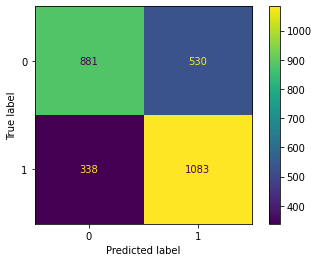

Accuracy:  0.693502824858757
Recall 0.7621393384940183
Precision  0.6714197148171109
F1  0.7139090309822017
ROC AUC  0.6932596054624591


In [ ]:
# Evaluate
predictions_T = clf_svm_T.predict(X_T_test)
cm = confusion_matrix(Y_T_test, predictions_T)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print("Accuracy: ", accuracy_score(Y_T_test, predictions_T))
print("Recall", recall_score(Y_T_test, predictions_T))
print("Precision ", precision_score(Y_T_test, predictions_T))
print("F1 ", f1_score(Y_T_test, predictions_T))
print("ROC AUC ", roc_auc_score(Y_T_test, predictions_T))

### Homicide

In [ ]:
# Train
clf_svm_H = SVC(random_state=123)
clf_svm_H.fit(X_H_train, Y_H_train)

# Evaluate
predictions_H = clf_svm_H.predict(X_H_test)

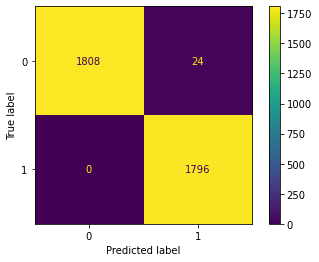

Accuracy:  0.9933847850055126
Recall 1.0
Precision  0.9868131868131869
F1  0.9933628318584071
ROC AUC  0.9934497816593886


In [ ]:
cm = confusion_matrix(Y_H_test, predictions_H)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print("Accuracy: ", accuracy_score(Y_H_test, predictions_H))
print("Recall", recall_score(Y_H_test, predictions_H))
print("Precision ", precision_score(Y_H_test, predictions_H))
print("F1 ", f1_score(Y_H_test, predictions_H))

## Hyperparameter Tuning

### Theft

In [ ]:
# Check default values
# Source: https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb
params = clf_svm_T.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,1.0
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,scale
kernel,rbf
max_iter,-1


In [ ]:
# Grid Search
## List of C values
C_range = np.logspace(-1, 1, 3)
print(f'The list of values for C are {C_range}')

## List of gamma values
gamma_range = np.logspace(-1, 1, 3)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [ 0.1  1.  10. ]
The list of values for gamma are [ 0.1  1.  10. ]


In [ ]:
# Space
space = {
    'C' : hp.choice('C', C_range),
    'gamma' : hp.choice('gamma', gamma_range.tolist()+['scale', 'auto']),
    'kernel' : hp.choice('kernel', ['rbf', 'poly'])
}

In [ ]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Objective function
def objective(params):
    
    svc = clf_svm_T
    scores = cross_val_score(svc, X_T_train, Y_T_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = np.mean(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Optimise
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = bayes_trials)

In [ ]:
# Print the index of the best parameters
print(best)
print(space_eval(space, best))

{'C': 1, 'gamma': 0, 'kernel': 0}
{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}


### Homicide

In [ ]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
# Objective function
def objective(params):
    
    svc = clf_svm_H
    scores = cross_val_score(svc, X_H_train, Y_H_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = np.mean(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = bayes_trials)
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

100%|██████████| 100/100 [06:35<00:00,  3.96s/trial, best loss: -0.9911784357538523]
{'C': 0, 'gamma': 3, 'kernel': 1}
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


## Modelling With Tuned Hyperparameters



### Theft

In [ ]:
best_T = {'C': 1, 'gamma': 0, 'kernel': 0}
# Train
clf_svm_T_opt = SVC(random_state=123, C=space_eval(space, best_T)['C'], gamma=space_eval(space, best_T)['gamma'], kernel=space_eval(space, best_T)['kernel'])
clf_svm_T_opt.fit(X_T_train, Y_T_train)

SVC(gamma=0.1, random_state=123)

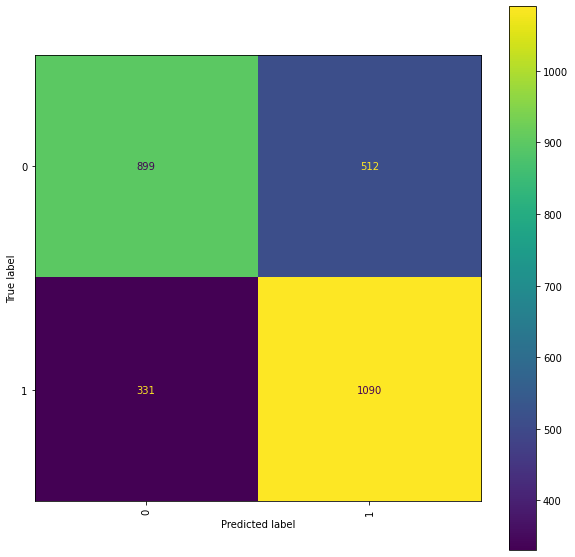

Accuracy:  0.7023305084745762
Recall 0.7670654468684025
Precision  0.6803995006242197
F1  0.7211379424412835
ROC AUC  0.7021011146461076


In [ ]:
# Evaluate
predictions_T = clf_svm_T_opt.predict(X_T_test)
cm = confusion_matrix(Y_T_test, predictions_T)
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('white')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical', ax=ax)
plt.show()

print("Accuracy: ", accuracy_score(Y_T_test, predictions_T))
print("Recall", recall_score(Y_T_test, predictions_T))
print("Precision ", precision_score(Y_T_test, predictions_T))
print("F1 ", f1_score(Y_T_test, predictions_T))
print("ROC AUC ", roc_auc_score(Y_T_test, predictions_T))

### Homicide

In [ ]:
best_H = {'C': 0, 'gamma': 3, 'kernel': 1}
clf_svm_H_opt = SVC(random_state=123, C=space_eval(space, best_H)['C'], gamma=space_eval(space, best_H)['gamma'], kernel=space_eval(space, best_H)['kernel'])
clf_svm_H_opt.fit(X_H_train, Y_H_train)

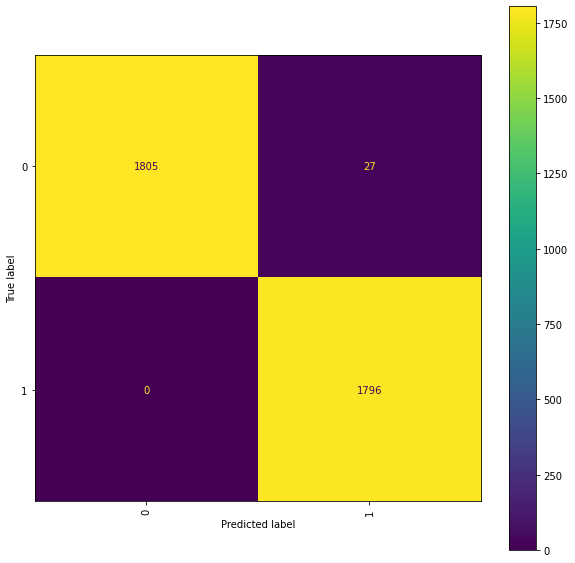

Accuracy:  0.9925578831312017
Recall 1.0
Precision  0.9851892484914976
F1  0.9925393755180989
ROC AUC  0.9926310043668123


In [ ]:
# Evaluate
predictions_H = clf_svm_H_opt.predict(X_H_test)
cm = confusion_matrix(Y_H_test, predictions_H)
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('white')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical', ax=ax)
plt.show()

print("Accuracy: ", accuracy_score(Y_H_test, predictions_H))
print("Recall", recall_score(Y_H_test, predictions_H))
print("Precision ", precision_score(Y_H_test, predictions_H))
print("F1 ", f1_score(Y_H_test, predictions_H))
print("ROC AUC ", roc_auc_score(Y_H_test, predictions_H))

###  Shapley Additive Explanations

In [ ]:
best_T = {'C': 1, 'gamma': 0, 'kernel': 0}
best_H = {'C': 0, 'gamma': 3, 'kernel': 1}

# Retrain with probability estimates enabled as required by Shapley
clf_svm_T_p = SVC(random_state=123, 
                  probability=True).fit(X_T_train, Y_T_train)

clf_svm_H_p = SVC(random_state=123, 
                  probability=True).fit(X_H_train, Y_H_train)

clf_svm_T_opt_p = SVC(random_state=123, 
                    C=space_eval(space, best_T)['C'], 
                    gamma=space_eval(space, best_T)['gamma'], 
                    kernel=space_eval(space, best_T)['kernel'], 
                    probability=True).fit(X_T_train,Y_T_train)
                    
clf_svm_H_opt_p = SVC(random_state=123, 
                    C=space_eval(space, best_H)['C'], 
                    gamma=space_eval(space, best_H)['gamma'], 
                    kernel=space_eval(space, best_H)['kernel'], 
                    probability=True).fit(X_H_train,Y_H_train)


In [ ]:
# Pickle data for later use
classifiers = {
              "Theft": clf_svm_T_p,
               "Homicide": clf_svm_H_p, 
               "Theft Optimised": clf_svm_T_opt_p, 
               "Homicide Optimised": clf_svm_H_opt_p
               }
datasets = {
    "X_T_train":X_T_train,
    "X_H_train":X_H_train, 
    "X_T_test" :X_T_test,
    "X_H_test" :X_H_test
}           

all  = {"classifiers":classifiers, 
        "datasets": datasets}
fn = "datasets_and_trained_classifiers.plk"

with open(fn, "wb") as f: 
  pickle.dump(all, f)

In [ ]:
# Upload pickled file to G-Drive

#gfile = drive.CreateFile({'parents': [{'id': '14QwYcEUTrm6_Rbc1_ApI9Q2K1nxBkKdh'}]})
#gfile.SetContentFile(fn)
#gfile.Upload() 
#!rm "{fn}"

In [ ]:
# Load the pickled file
fn = "datasets_and_trained_classifiers.plk"
downloaded_file = drive.CreateFile({ 'id': '1tqTWfOeeZfxb0Ji99UBChKpPATH1CijC' }) # kieron
downloaded_file.GetContentFile(fn)  

In [ ]:
with open(fn, "rb") as f: 
  all_data = pickle.load(f) 

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

Sharp values for classifier :Theft


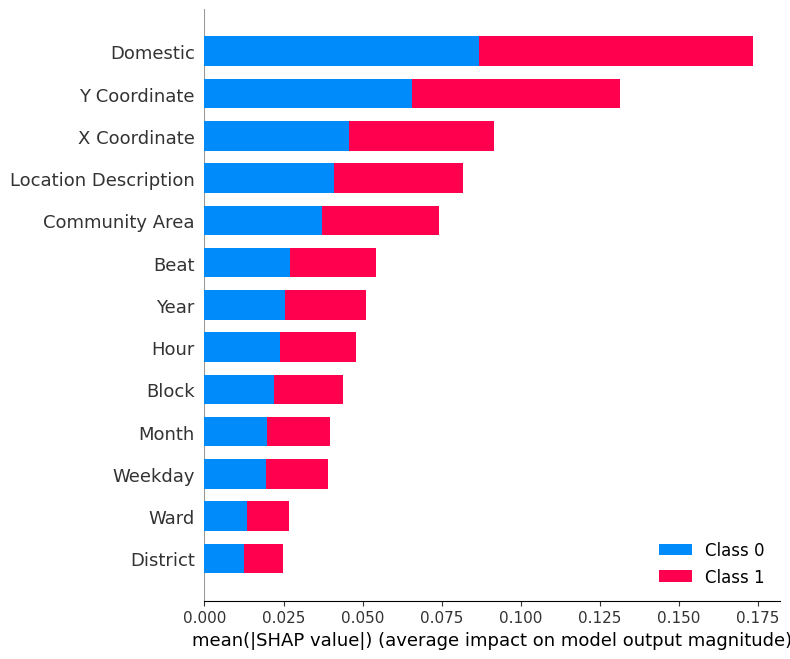

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

Sharp values for classifier :Homicide


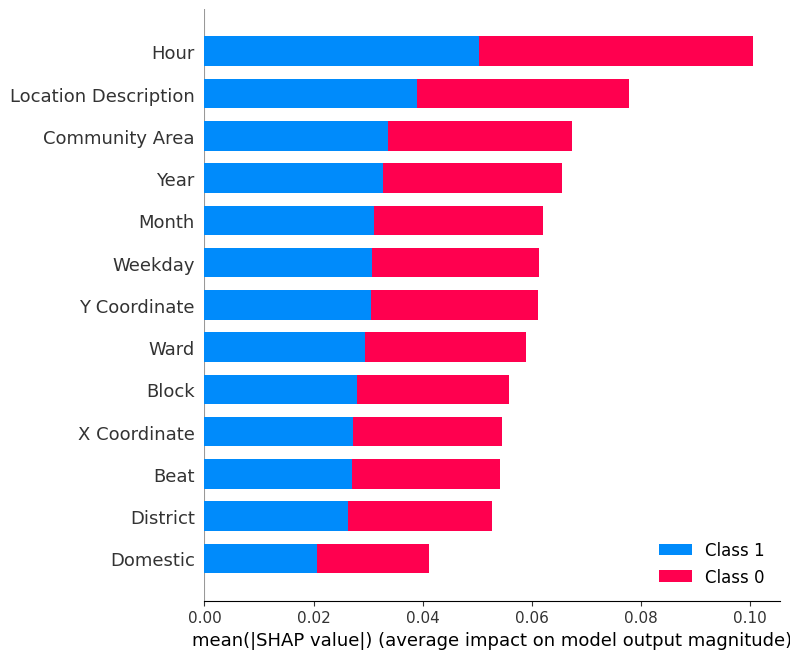

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

Sharp values for classifier :Theft Optimised


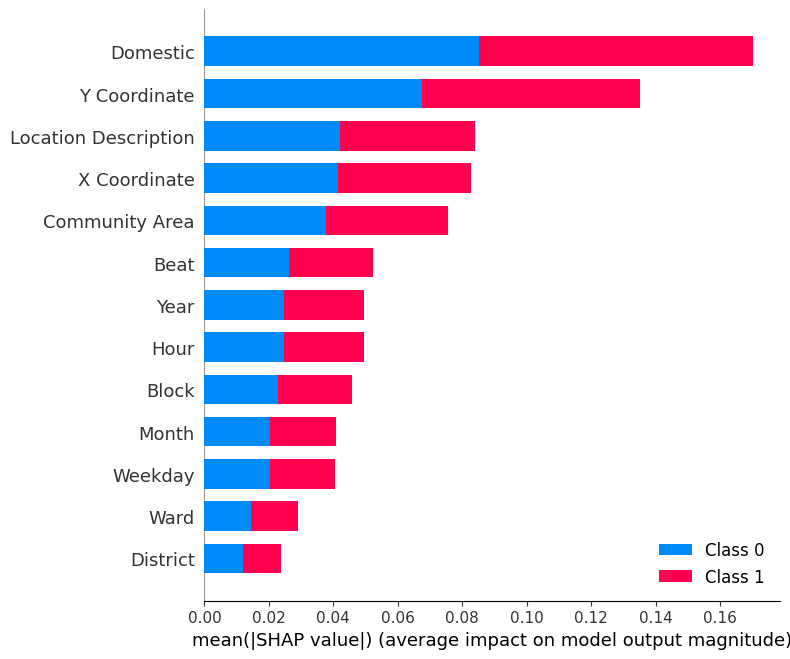

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

Sharp values for classifier :Homicide Optimised


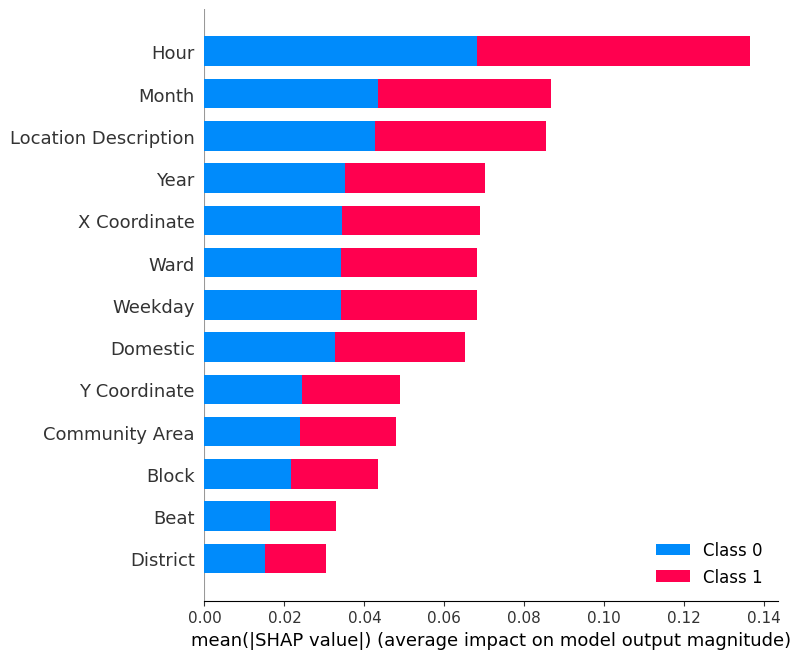

In [ ]:
# Calculate the Shapley additive explanations for our model.

feature_names = all_data["datasets"]["X_T_train"].columns

for name, classifier in all_data["classifiers"].items(): 
  if name[0]=="T": training_data = all_data["datasets"]["X_T_train"]
  elif name[0]=="H": training_data = all_data["datasets"]["X_H_train"]
  # Sampling to reduce computational time
  n = 4000
  training_data = shap.sample(training_data,n )
  # Cluser to reduce computational time
  k = 100
  training_data = shap.kmeans(training_data, k).data

  explainer = shap.KernelExplainer(classifier.predict_proba, training_data)
  shap_values = explainer.shap_values(training_data, feature_names = feature_names,nsamples=100)
  plt.plot()
  shap.summary_plot(shap_values, 
                    features = training_data, 
                    feature_names = feature_names, 
                    show=False,
                    )
  print(f"Sharp values for classifier :{name}")
  plt.savefig(f"Shap {name}.png")
  plt.show()

## Evaluating the Effectiveness of SMOTE

In [ ]:
# Theft data without SMOTE and undersampling
X_T_train, X_T_test, Y_T_train, Y_T_test = train_test_split(X_ref, Y_T, test_size = 0.2, random_state = 123)

In [ ]:
# Train our Theft SVM
clf_svm_T = SVC(random_state=123).fit(X_T_train,Y_T_train)

In [ ]:
# Grid Search

# List of C values
C_range = np.logspace(-1, 1, 3)
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = np.logspace(-1, 1, 3)
print(f'The list of values for gamma are {gamma_range}')

# Space
space = {
    'C' : hp.choice('C', C_range),
    'gamma' : hp.choice('gamma', gamma_range.tolist()+['scale', 'auto']),
    'kernel' : hp.choice('kernel', ['rbf', 'poly'])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
# Objective function
def objective(params):
    svc = clf_svm_T
    scores = cross_val_score(svc, X_T_train, Y_T_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = np.mean(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = bayes_trials)
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

The list of values for C are [ 0.1  1.  10. ]
The list of values for gamma are [ 0.1  1.  10. ]
100%|██████████| 100/100 [07:39<00:00,  4.59s/trial, best loss: -0.7784810989372764]
{'C': 1, 'gamma': 3, 'kernel': 0}
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
best_T = {'C': 1, 'gamma': 0, 'kernel': 0}
#best_T = best

clf_svm_T_opt = SVC(random_state=123, 
                    C=space_eval(space, best_T)['C'], 
                    gamma=space_eval(space, best_T)['gamma'], 
                    kernel=space_eval(space, best_T)['kernel'], 
                    probability=False).fit(X_T_train,Y_T_train)

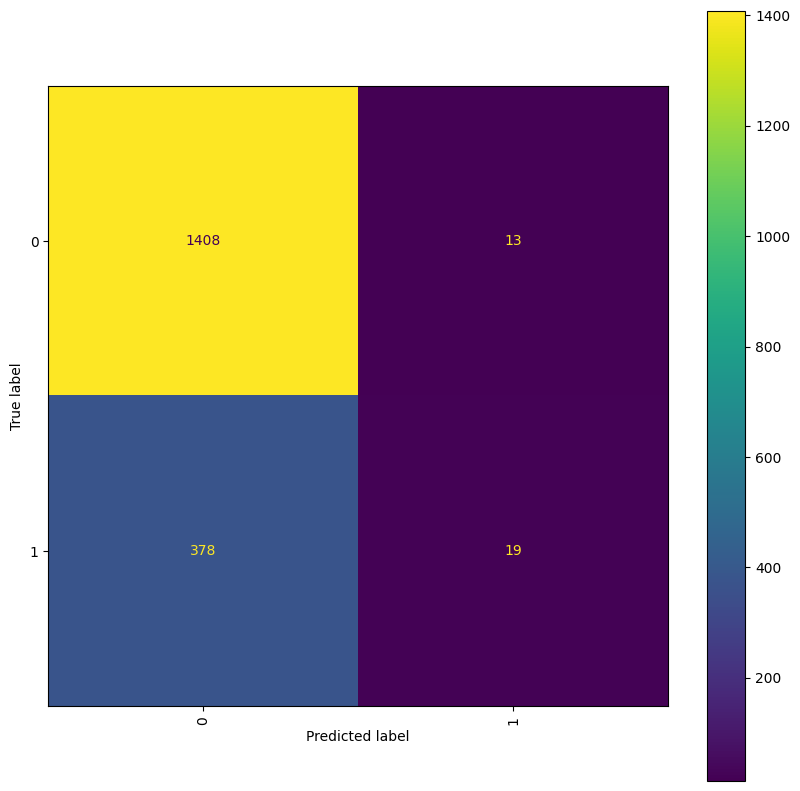

Accuracy:  0.7849284928492849
Recall 0.04785894206549118
Precision  0.59375
F1  0.08857808857808859
ROC AUC  0.519355227542246


In [ ]:
# Evaluate
predictions_T = clf_svm_T_opt.predict(X_T_test)
cm = confusion_matrix(Y_T_test, predictions_T)
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('white')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical', ax=ax)
plt.show()

print("Accuracy: ", accuracy_score(Y_T_test, predictions_T))
print("Recall", recall_score(Y_T_test, predictions_T))
print("Precision ", precision_score(Y_T_test, predictions_T))
print("F1 ", f1_score(Y_T_test, predictions_T))
print("ROC AUC ", roc_auc_score(Y_T_test, predictions_T))